In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib','inline')
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb

sns.set(style='white', context='notebook', palette='deep')

In [4]:
client_test = pd.read_csv('client_test.csv')
client_train = pd.read_csv('client_train.csv')
invoice_test = pd.read_csv('invoice_test.csv')
invoice_train = pd.read_csv('invoice_train.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

In [5]:
client_train['creation_date']= pd.to_datetime(client_train['creation_date'])

In [6]:
client_test['creation_date']= pd.to_datetime(client_test['creation_date'])

In [7]:
invoice_train['invoice_date']= pd.to_datetime(invoice_train['invoice_date'])

In [8]:
invoice_test['invoice_date']= pd.to_datetime(invoice_test['invoice_date'])

In [9]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  int64         
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  int64         
 3   region         135493 non-null  int64         
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.2+ MB


In [10]:
client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   disrict        58069 non-null  int64         
 1   client_id      58069 non-null  object        
 2   client_catg    58069 non-null  int64         
 3   region         58069 non-null  int64         
 4   creation_date  58069 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.2+ MB


In [12]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        object        
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
dtypes: datetime64[ns](1), int64(12), object(3)
memory usage: 546.5+ MB


In [11]:
invoice_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1939730 entries, 0 to 1939729
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        int64         
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
dtypes: datetime64[ns](1), int64(13), object(2)
memory usage: 236.8+ MB


In [7]:
client_test.shape, client_train.shape, invoice_test.shape, invoice_train.shape

((58069, 5), (135493, 6), (1939730, 16), (4476749, 16))

In [8]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [13]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [11]:
invoice_test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [36]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
sample_submission.head()

,client_id,target
0,test_Client_0,0.957281
1,test_Client_1,0.996425
2,test_Client_10,0.612359
3,test_Client_100,0.776933
4,test_Client_1000,0.571046


In [22]:
client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


In [20]:
invoice_train.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [23]:
invoice_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1939730 entries, 0 to 1939729
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        int64 
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(13), object(3)
memory usage: 236.8+ MB


In [24]:
invoice_test.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [14]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [13]:
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [9]:
occ = client_train['target'].value_counts()
occ

0.0    127927
1.0      7566
Name: target, dtype: int64

In [6]:
temp = client_train["target"].value_counts()
df = pd.DataFrame({'target': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['target'],y = df['values'],
    name="Fraud Detection - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Fraud Detection - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'target', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='target')

In [21]:
target_0 = client_train.loc[client_train['target'] == 0]["disrict"]
target_1 = client_train.loc[client_train['target'] == 1]["disrict"]

hist_data = [target_0, target_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Client District Density Plot', xaxis=dict(title='Disrict'))
iplot(fig, filename='dist_only')

In [23]:
target_0 = client_train.loc[client_train['target'] == 0]["region"]
target_1 = client_train.loc[client_train['target'] == 1]["region"]

hist_data = [target_0, target_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Client Region Density Plot', xaxis=dict(title='region'))
iplot(fig, filename='dist_only')

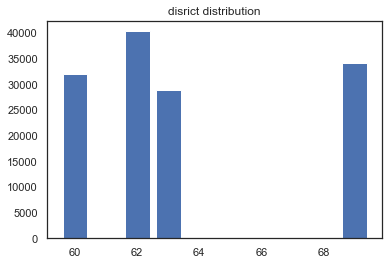

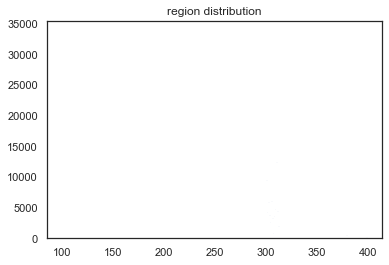

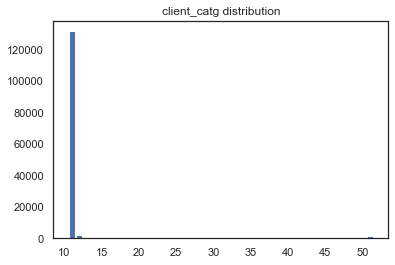

In [51]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [26]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())
print('Number of missing rows in invoice_test:',invoice_test.isna().sum().sum(),'\n')
print('Number of missing rows in client_train:',client_train.isna().sum().sum())
print('Number of missing rows in client_test:',client_test.isna().sum().sum())

Number of missing rows in invoice_train: 0
Number of missing rows in invoice_test: 0 

Number of missing rows in client_train: 0
Number of missing rows in client_test: 0


In [27]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [28]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [31]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [34]:
client_train1

,disrict,client_id,client_catg,region,creation_date,target,region_group,coop_time
0,60,train_Client_0,11,101,1994-12-31,0.0,200,288
1,69,train_Client_1,11,107,2002-05-29,0.0,200,199
2,62,train_Client_10,11,301,1986-03-13,0.0,300,393
3,69,train_Client_100,11,105,1996-11-07,0.0,200,265
4,62,train_Client_1000,11,303,2014-10-14,0.0,300,50
...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0,300,173
135489,63,train_Client_99996,11,311,2012-10-25,0.0,300,74
135490,63,train_Client_99997,11,311,2011-11-22,0.0,300,85
135491,60,train_Client_99998,11,101,1993-12-22,0.0,200,300


In [35]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [39]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [41]:
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58069 entries, 0 to 58068
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   disrict                    58069 non-null  category      
 1   client_id                  58069 non-null  object        
 2   client_catg                58069 non-null  category      
 3   region                     58069 non-null  category      
 4   creation_date              58069 non-null  datetime64[ns]
 5   region_group               58069 non-null  int64         
 6   coop_time                  58069 non-null  int64         
 7   is_weekday_mean            58069 non-null  float64       
 8   transactions_count         58069 non-null  int64         
 9   tarif_type_mean            58069 non-null  float64       
 10  tarif_type_std             56309 non-null  float64       
 11  tarif_type_min             58069 non-null  int64         
 12  tari

In [44]:
test_df1.head()

,disrict,client_id,client_catg,region,creation_date,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,...,invoice_year_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_time_mean,delta_time_std,delta_time_min,delta_time_max,invoice_per_cooperation
0,62,test_Client_0,11,307,2002-05-28,300,199,0.027027,37,11.000000,...,2019,491.378378,235.684859,0,1090,137.972222,44.900834,101.0,251.0,0.185930
1,69,test_Client_1,11,103,2009-06-08,200,114,0.227273,22,11.000000,...,2019,2703.181818,3200.849986,11,14899,178.285714,117.157647,27.0,434.0,0.192982
2,62,test_Client_10,11,310,2004-07-04,300,173,0.000000,74,23.540541,...,2019,607.310811,422.779872,0,2012,68.794521,61.954723,0.0,175.0,0.427746
3,60,test_Client_100,11,101,1992-08-10,200,316,0.050000,40,25.500000,...,2012,244.350000,247.253171,0,721,63.743590,94.363440,0.0,365.0,0.126582
4,62,test_Client_1000,11,301,1977-07-21,300,497,0.094340,53,20.849057,...,2019,749.113208,864.294814,0,3900,98.788462,99.893539,0.0,414.0,0.106640


In [43]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Data columns (total 79 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   disrict                    135493 non-null  category      
 1   client_id                  135493 non-null  object        
 2   client_catg                135493 non-null  category      
 3   region                     135493 non-null  category      
 4   creation_date              135493 non-null  datetime64[ns]
 5   target                     135493 non-null  float64       
 6   region_group               135493 non-null  int64         
 7   coop_time                  135493 non-null  int64         
 8   is_weekday_mean            135493 non-null  float64       
 9   transactions_count         135493 non-null  int64         
 10  tarif_type_mean            135493 non-null  float64       
 11  tarif_type_std             131281 non-null  float64 

In [45]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [46]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [48]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58069 entries, 0 to 58068
Columns: 110 entries, disrict to delta_index_max_mean
dtypes: category(3), datetime64[ns](1), float64(54), int64(51), object(1)
memory usage: 48.0+ MB


In [49]:
occ = train_df2['target'].value_counts()
occ

0.0    127927
1.0      7566
Name: target, dtype: int64

In [50]:
temp = train_df2["target"].value_counts()
df = pd.DataFrame({'target': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['target'],y = df['values'],
    name="Fraud Detection - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Fraud Detection - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'target', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='target')